In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import numba as nb
import pandas as pd
from numba import jit
import matplotlib.pyplot as plt
import itertools
import os

import coherent_summation_interface.microseismic_monitoring as mm

In [3]:
def patch_system_construct(area_grid, patch_grid, xyz_min, xyz_max):
    '''
    Construct patch system on area with coordinates 'xyz_min, xyz_max'
    
    Parameters
    ----------
    area_grid : array_like (1 dimensional)
        Patches grid on area (nx, ny)
    patch_grid : array_like (3_dimensional)
        Relatively receivers coordinates in patch
    '''
    nx, ny = area_grid
    x0, y0 = xyz_min[0], xyz_min[1]
    x1, y1 = xyz_max[0], xyz_max[1]
    dx = (x1 - x0 - np.max(patch_grid[:, 0])) / (nx - 1)
    dy = (y1 - y0 - np.max(patch_grid[:, 1])) / (ny - 1)
            
    recs_coords = np.array([patch_grid + np.array([x0 + dx*i_x, y0 + dy*i_y, 0.0]) for i_x, i_y in itertools.product(range(nx), range(ny))]).reshape((-1, 3))
        
    return recs_coords

def patch_system_generate(xyz_min, xyz_max, area_grid, n_recs_in_line, n_lines, d_recs, d_lines):
    patch_grid = np.concatenate((np.dstack(np.meshgrid(np.linspace(0.0, d_recs*(n_recs_in_line-1), n_recs_in_line), 
                                                       np.linspace(0.0, d_lines*(n_lines-1), n_lines))
                                          ),
                               np.zeros((n_lines, n_recs_in_line, 1))), axis=-1).reshape((-1, 3))
    
    return patch_system_construct(area_grid, patch_grid, xyz_min, xyz_max)

In [4]:
@jit(nopython=True, parallel=True)
def calculate_travel_times_vertical_gradient(v0, dv, xyz, recs):
    rev_dv = (1 / dv)
    dv_square = dv ** 2
    
    r_xyz_diff = (recs - xyz)
    r_xyz_dist = (r_xyz_diff**2).sum(axis=-1)
    v = v0 + dv*xyz[..., -1]
    
    return rev_dv*np.arccosh(1 + (dv_square * r_xyz_dist) / (2*v*(dv*r_xyz_diff[..., -1] + v)))

@jit(nopython=True, parallel=True)
def calculate_travel_times_vertical_gradient_for_model(v0, dv, xyz_min, xyz_max, nxyz, recs):
    dxyz = (xyz_max - xyz_min) / (nxyz - 1)
    
    travel_times = np.empty((len(recs), nxyz[2], nxyz[1], nxyz[0]), dtype=np.float32)
    
    rev_dv = (1.0 / dv)
    dv_square = dv ** 2
    
    for i_z in nb.prange(nxyz[2]):
        for i_y in nb.prange(nxyz[1]):
            for i_x in nb.prange(nxyz[0]):
                i_xyz = np.array([i_x, i_y, i_z])
                xyz = xyz_min + dxyz*i_xyz
                
                r_xyz_diff = (recs - xyz)
                r_xyz_dist = (r_xyz_diff**2).sum(axis=-1)
                v = v0 + dv*xyz[..., -1]
                travel_times[:, i_z, i_y, i_x] = rev_dv*np.arccosh(1 + 
                    (dv_square * r_xyz_dist) / 
                    (2 * v * (dv * r_xyz_diff[..., -1] + v))
                )

    return travel_times

def calculate_travel_times_vertical_gradient_by_partitions(v0, dv, xyz_min, xyz_max, nxyz, recs, fid_prefix):
    recs_block = 20
    recs_len = len(recs)
    with open(fid_prefix + '.bin', 'wb') as travel_times_file_binary, open(fid_prefix + '.csv', 'w') as travel_times_file_csv:
        for i in range(0, recs_len, recs_block):
            curr_block_size = min(recs_block, recs_len - i)
            travel_times = calculate_travel_times_vertical_gradient_for_model(v0, dv, xyz_min, xyz_max, nxyz, recs[i:i+curr_block_size, ...]).reshape(curr_block_size, -1)
            travel_times_file_binary.write(travel_times.tobytes())
            np.savetxt(travel_times_file_csv, travel_times, delimiter=';', fmt='%.4e')

In [5]:
@jit(nopython=True, parallel=True)
def gaussian_noise(n_recs, ns, ampl=1.0):
    return np.random.standard_normal((n_recs, ns)) * ampl

def generate_gather_gaussian_noise(n_recs, ns, n_files, fid_prefix, ampl=1.0):
    for i_f in range(n_files):
        gather = gaussian_noise(n_recs, ns, ampl).astype(np.float32)
        gather.tofile(fid_prefix + '_{}.bin'.format(i_f))
    return

In [6]:
@jit(nopython=True, parallel=True)
def ricker_impulse(t, freq, ampl=1.0):
    omega = np.pi * freq
    omega_t_sqr = (omega * t) ** 2
    imp = ampl * (1 - ((omega_t_sqr) * 2)) * np.exp(-omega_t_sqr)
    return imp

@jit(nopython=True, parallel=True)
def add_event_to_gather(gather, travel_times, dt, freq=40.0, ampl=1.0):
    ns = gather.shape[-1]
    n_recs = len(travel_times)
    t_seq = np.linspace(0.0, dt * (ns - 1), ns)
        
    for i_r in nb.prange(n_recs):
        gather[i_r, ...] += ricker_impulse((t_seq - travel_times[i_r, ...]), freq, ampl)
        
    return gather

def add_events(recs, sources, fid_prefix, n_files, dt, v0, dv):
    n_sou = len(sources)
    n_recs = len(recs)
    delta = 0.4
    file_gather_step = n_files // n_sou
    for i_f, i_sou in zip(range(0, n_files, file_gather_step), range(n_sou)):
        gather_filename = fid_prefix + '_{}.bin'.format(i_f)
        gather = np.fromfile(gather_filename, dtype=np.float32).reshape((n_recs, -1))
        travel_times = calculate_travel_times_vertical_gradient(v0, dv, sources[i_sou], recs)
        gather_with_event = add_event_to_gather(gather, travel_times + delta * i_sou, dt, freq=10., ampl=1000.)
        gather_with_event.tofile(gather_filename)

In [7]:
x0, y0, z0 = -3000.0, -3000.0, 0.0
x1, y1, z1 = 3000.0, 3000.0, 4000.0
dt = 0.001
n_seismograms = 60*24
v0 = 1000.0
v1 = 4000.0
nx = 30
ny = 30
nz = 30
xyz_min = np.array([x0, y0, z0])
xyz_max = np.array([x1, y1, z1])
dv = (v1 - v0) / (xyz_max[..., -1] - xyz_min[..., -1])
trace_time_s = 60
ns = int(trace_time_s / dt)

gather_prefix_dir = '/mnt/nfs/Data/vershinin/microseismic/gather'
if not os.path.exists(gather_prefix_dir):
    os.makedirs(gather_prefix_dir)
gather_prefix_name = 'gather'
gather_prefix = os.path.join(gather_prefix_dir, gather_prefix_name)

gather_prefix_patch = '{}_patch'.format(gather_prefix)
gather_prefix_rays = '{}_rays'.format(gather_prefix)

result_prefix_dir = '/mnt/nfs/Data/vershinin/microseismic/result'
if not os.path.exists(result_prefix_dir):
    os.makedirs(result_prefix_dir)
result_prefix_name = 'result'
result_prefix = os.path.join(result_prefix_dir, result_prefix_name)

result_prefix_patch = '{}_patch'.format(result_prefix)
result_prefix_rays = '{}_rays'.format(result_prefix)

detect_function_prefix_name = 'detect_function'
detect_function_prefix = os.path.join(result_prefix_dir, detect_function_prefix_name)

detect_function_prefix_patch = '{}_patch'.format(detect_function_prefix)
detect_function_prefix_rays = '{}_rays'.format(detect_function_prefix)

times_table_prefix_dir = '/mnt/nfs/Data/vershinin/microseismic/times_table'
if not os.path.exists(times_table_prefix_dir):
    os.makedirs(times_table_prefix_dir)
times_table_prefix_name = 'times_table'
times_table_prefix = os.path.join(times_table_prefix_dir, times_table_prefix_name)

times_table_prefix_patch = '{}_patch'.format(times_table_prefix)
times_table_prefix_rays = '{}_rays'.format(times_table_prefix)

# Observing system generation
<a id="observing_system"></a>

In [8]:
recs_rays = np.load('recs_rays.npy')

In [9]:
np.save('recs_rays', recs_rays)

In [10]:
recs_patch = patch_system_generate(xyz_min, xyz_max, np.array([6, 6]), 12, 4, 10., 40.)

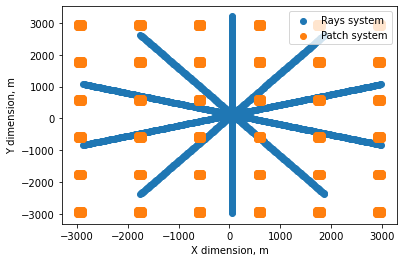

In [11]:
plt.figure()
plt.scatter(recs_rays[:, 0], recs_rays[:, 1], cmap="Blue", label="Rays system")
plt.scatter(recs_patch[:, 0], recs_patch[:, 1], cmap="Orange", label="Patch system")
plt.legend(loc="upper right")
plt.ylabel("Y dimension, m")
plt.xlabel("X dimension, m")
plt.show()

In [12]:
np.save('recs_patch', recs_patch)

<hr>

# Vertical velocity model generate
<a id="velocity_model"></a>

In [17]:
dx = (x1 - x0) / (nx - 1)
dy = (y1 - y0) / (ny - 1)
dz = (z1 - z0) / (nz - 1)
velocities = np.linspace(np.full((ny, nx), v0), np.full((ny, nx), v1), nz)

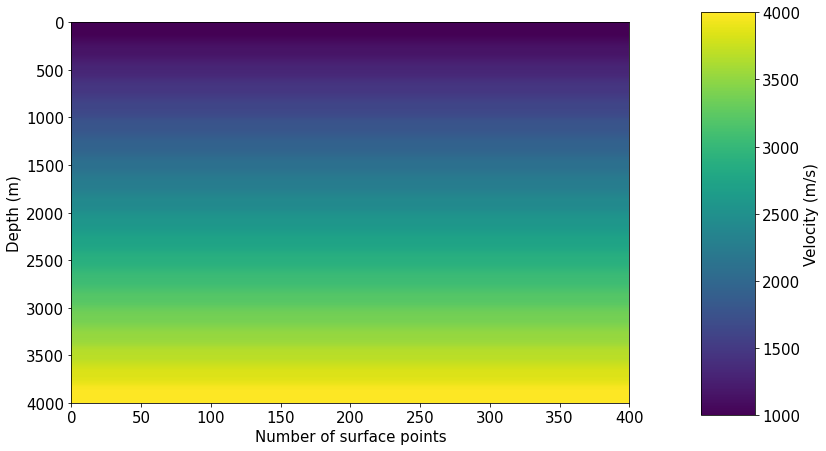

In [19]:
plt.figure(figsize=(10, 7))
plt.rcParams['font.size'] = 15
extent = np.array([0, nx*ny, xyz_max[-1], xyz_min[-1]])
im = plt.imshow(velocities.reshape((nz, -1)), extent=extent, aspect='auto')
plt.xlabel('Number of surface points')
plt.ylabel('Depth (m)')
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(mappable=im, cax=cax, label='Velocity (m/s)')
plt.show()

In [19]:
np.save('velocity', velocities)

In [20]:
velocities.shape

(20, 20, 20)

<hr>

# Travel times generate
<a id="travel_times"></a>

In [8]:
local_xyz_min = np.array([-1500., -1500., 0.]);
local_xyz_max = np.array([1500., 1500., 3500.])

recs_rays = np.load('recs_rays.npy')
recs_patch = np.load('recs_patch.npy')
recs = np.concatenate((recs_rays, recs_patch), axis=0)

In [9]:
calculate_travel_times_vertical_gradient_by_partitions(v0, dv, local_xyz_min, local_xyz_max, np.array([nx, ny, nz]), recs, times_table_prefix)

In [15]:
# Only for rays observate system

# calculate_travel_times_vertical_gradient_by_partitions(v0, dv, local_xyz_min, local_xyz_max, np.array([nx, ny, nz]), recs_rays, times_table_prefix_rays)

In [16]:
# Only for patch observate system

# calculate_travel_times_vertical_gradient_by_partitions(v0, dv, local_xyz_min, local_xyz_max, np.array([nx, ny, nz]), recs_patch, times_table_prefix_patch)

# Synthetic seismograms noise generate
<a id="synthetic_seismograms_noise"></a>

In [17]:
recs_rays = np.load('recs_rays.npy')
recs_patch = np.load('recs_patch.npy')
recs = np.concatenate((recs_rays, recs_patch), axis=0)

In [18]:
n_recs = len(recs)
generate_gather_gaussian_noise(n_recs, ns, n_seismograms, gather_prefix)

In [ ]:
# Only for patch observate system

# n_recs = len(recs_patch)
# generate_gather_gaussian_noise(n_recs, ns, n_seismograms, gather_prefix_patch)

In [ ]:
# Only for rays observate system

# n_recs = len(recs_rays)
# generate_gather_gaussian_noise(n_recs, ns, n_seismograms, gather_prefix_rays)

<hr>

# Synthetic seismograms events generate
<a id="synthetic_seismograms_events"></a>

In [19]:
recs_rays = np.load('recs_rays.npy')
recs_patch = np.load('recs_patch.npy')
recs = np.concatenate((recs_rays, recs_patch), axis=0)

In [20]:
events_coords_df = pd.read_excel('eventsSergey2_true.xlsx')
events_coords = events_coords_df.values[..., 1:] * 1000

In [21]:
add_events(recs, events_coords, gather_prefix, n_seismograms, dt, v0, dv)

In [ ]:
# Only for patch observate system

# add_events(recs_patch, events_coords, gather_prefix_patch, n_seismograms, dt, v0, dv, delta)

In [ ]:
# Only for rays observate system

# add_events(recs_rays, events_coords, gather_prefix_rays, n_seismograms, dt, v0, dv, delta)

<hr>

# Test coherent summation
<a id="test_coherent_summation"></a>

In [14]:
def get_processing_result_detect_function(detect_function_prefix):
    
    def processing_result_detect_function(result, number):
        n_points, n_samples = result.shape
        
        detect_function = np.amax(result, axis=0)

#         detect_function = np.empty((n_samples), dtype=np.dtype([('i_p', '<i4'), ('event', 'f')]))
#         detect_function[:]['i_p'] = np.array([np.argmax(result[:, i_s]) for i_s in range(n_samples)])
#         detect_function[:]['event'] = np.array([np.max(result[:, i_s]) for i_s in range(n_samples)])

        np.save('{}_{}'.format(detect_function_prefix, number), detect_function)
        
    return processing_result_detect_function

In [15]:
recs_rays = np.load('recs_rays.npy')
recs_patch = np.load('recs_patch.npy')
recs = np.concatenate((recs_rays, recs_patch), axis=0)

In [ ]:
file_names = np.array(['{}_{}.bin'.format(gather_prefix, i) for i in range(n_seismograms)])
n_recs = len(recs)
travel_timetable = np.fromfile('{}.bin'.format(times_table_prefix), dtype=np.float32).reshape((n_recs, -1)).T
mm.emission_tomography_on_files(file_names, 
                                travel_timetable, 
                                dt, 
                                get_processing_result_detect_function(detect_function_prefix))

2332032.5
340.63498
339.10458


In [8]:
# Patch observing system

# patch_file_names = np.array(['{}_{}.bin'.format(gather_prefix_patch, i) for i in range(n_seismograms)])
# n_recs = len(recs_patch)
# patch_travel_timetable = np.fromfile('{}.bin'.format(times_table_prefix_patch), dtype=np.float32).reshape((n_recs, -1)).T
# mm.emission_tomography_on_files(patch_file_names, 
#                                 patch_travel_timetable, 
#                                 dt, 
#                                 get_processing_result_detect_function(detect_function_prefix_patch))

Gather remainder sample: 3984
Gather dtype: float64
Table times dtype: float32
Sleep before summation
After sleep


TypeError: emission_tomography(): incompatible function arguments. The following argument types are supported:
    1. (self: CoherentSummationModule.CoherentSummation, gather: numpy.ndarray[numpy.float64], sources_receivers_times: numpy.ndarray[numpy.float64], dt: float, receivers_block_size: int = 20, samples_block_size: int = 1000) -> numpy.ndarray[numpy.float64]
    2. (self: CoherentSummationModule.CoherentSummation, gather: numpy.ndarray[numpy.float64], sources_receivers_times: numpy.ndarray[numpy.float32], dt: float, receivers_block_size: int = 20, samples_block_size: int = 1000) -> numpy.ndarray[numpy.float64]
    3. (self: CoherentSummationModule.CoherentSummation, gather: numpy.ndarray[numpy.float32], sources_receivers_times: numpy.ndarray[numpy.float64], dt: float, receivers_block_size: int = 20, samples_block_size: int = 1000) -> numpy.ndarray[numpy.float32]
    4. (self: CoherentSummationModule.CoherentSummation, gather: numpy.ndarray[numpy.float32], sources_receivers_times: numpy.ndarray[numpy.float32], dt: float, receivers_block_size: int = 20, samples_block_size: int = 1000) -> numpy.ndarray[numpy.float32]
    5. (self: CoherentSummationModule.CoherentSummation, gather: numpy.ndarray[numpy.float64], receivers_coords: numpy.ndarray[numpy.float64], sources_coords: numpy.ndarray[numpy.float64], sources_receivers_times: numpy.ndarray[numpy.float64], dt: float, tensor_matrix: numpy.ndarray[numpy.float64], receivers_block_size: int = 20, samples_block_size: int = 1000) -> numpy.ndarray[numpy.float64]
    6. (self: CoherentSummationModule.CoherentSummation, gather: numpy.ndarray[numpy.float64], receivers_coords: numpy.ndarray[numpy.float64], sources_coords: numpy.ndarray[numpy.float64], sources_receivers_times: numpy.ndarray[numpy.float32], dt: float, tensor_matrix: numpy.ndarray[numpy.float64], receivers_block_size: int = 20, samples_block_size: int = 1000) -> numpy.ndarray[numpy.float64]
    7. (self: CoherentSummationModule.CoherentSummation, gather: numpy.ndarray[numpy.float32], receivers_coords: numpy.ndarray[numpy.float32], sources_coords: numpy.ndarray[numpy.float32], sources_receivers_times: numpy.ndarray[numpy.float64], dt: float, tensor_matrix: numpy.ndarray[numpy.float32], receivers_block_size: int = 20, samples_block_size: int = 1000) -> numpy.ndarray[numpy.float32]
    8. (self: CoherentSummationModule.CoherentSummation, gather: numpy.ndarray[numpy.float32], receivers_coords: numpy.ndarray[numpy.float32], sources_coords: numpy.ndarray[numpy.float32], sources_receivers_times: numpy.ndarray[numpy.float32], dt: float, tensor_matrix: numpy.ndarray[numpy.float32], receivers_block_size: int = 20, samples_block_size: int = 1000) -> numpy.ndarray[numpy.float32]

Invoked with: <CoherentSummationModule.CoherentSummation object at 0x000001C02AB7D4B0>, array([[ 0.98650857, -0.15255424,  0.16196736, ..., -0.99900423,
         0.56538951,  1.20719433],
       [-0.61245577,  0.92081387,  0.72942296, ...,  0.04865118,
        -0.88743355, -0.56399189],
       [-0.47831362, -0.50858211, -1.58267205, ...,  0.17752398,
         1.73350085, -0.45515105],
       ...,
       [ 0.23516727, -0.30614187,  0.7076236 , ..., -1.68085377,
         0.80249546,  0.33794362],
       [ 0.30104248,  1.09259813,  0.31386043, ...,  2.64398999,
         0.18255492,  1.11366682],
       [-0.38561232, -0.68443151, -0.48786223, ..., -0.02120351,
         0.73127108, -0.49153412]]), array([[1.9443911, 1.9388632, 1.9333466, ..., 4.2724752, 4.2752075,
        4.27794  ],
       [2.0330155, 2.0273368, 2.021666 , ..., 4.229411 , 4.232134 ,
        4.2348576],
       [2.1235592, 2.117783 , 2.1120117, ..., 4.1865273, 4.1892366,
        4.191947 ],
       ...,
       [3.0234728, 3.0216613, 3.0198514, ..., 2.0141904, 2.0159185,
        2.0176537],
       [3.05231  , 3.050471 , 3.0486336, ..., 1.9878731, 1.9894845,
        1.9911035],
       [3.0815575, 3.0796938, 3.0778315, ..., 1.9634677, 1.9649543,
        1.9664489]], dtype=float32), 0.001

In [9]:
# Rays observing system

# rays_file_names = np.array(['{}_{}.bin'.format(gather_prefix_rays, i) for i in range(n_seismograms)])
# n_recs = len(recs_rays)
# rays_travel_timetable = np.fromfile('{}.bin'.format(times_table_prefix_rays), dtype=np.float32).reshape((n_recs, -1)).T
# mm.emission_tomography_on_files(rays_file_names, 
#                                 rays_travel_timetable, 
#                                 dt, 
#                                 get_processing_result_detect_function(detect_function_prefix_rays))

Gather remainder sample: 3705
1172418.9534373542
209.75152158232677
1252346.0214121877
233.740227217331
1279911.1676327516
222.97279007707823
1188517.3162778015
214.99370715997023
1194022.1040560976
224.66653659665286
213.32170315900234
221.06651178328784


<hr>

In [31]:
gather = np.fromfile('{}_0.bin'.format(gather_prefix), dtype=np.float32).reshape((-1, ns))

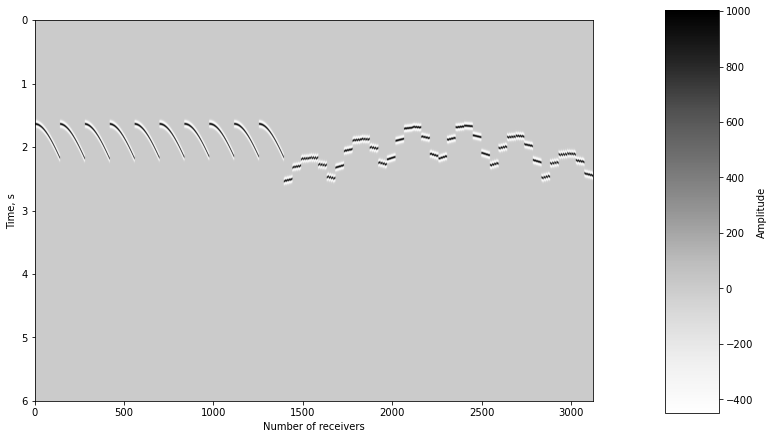

In [32]:
plt.figure(figsize=(10, 7))
gather_show_len = 6000
extent = np.array([0, len(recs), dt*gather_show_len, 0])
plt.imshow(gather[:, 0:gather_show_len].T, aspect='auto', cmap=plt.cm.Greys, extent=extent)
plt.xlabel('Number of receivers')
plt.ylabel('Time, s')
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax, label='Amplitude')
plt.show()

In [ ]:
gather_patch = np.fromfile('{}_0.bin'.format(gather_prefix_patch), dtype=np.float64).reshape((-1, ns))

In [ ]:
plt.figure(figsize=(10, 7))
gather_show_len = 10000
extent = np.array([0, len(recs_patch), dt*gather_show_len, 0])
plt.imshow(gather_patch[:, 0:gather_show_len].T, aspect='auto', cmap=plt.cm.Greys, extent=extent)
plt.xlabel('Number of receivers')
plt.ylabel('Time, s')
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax, label='Amplitude')
plt.show()

In [ ]:
gather_rays = np.fromfile('{}_0.bin'.format(gather_prefix_rays), dtype=np.float64).reshape((-1, ns))

In [ ]:
plt.figure(figsize=(10, 7))
gather_show_len = 10000
extent = np.array([0, len(recs_rays), dt*gather_show_len, 0])
plt.imshow(gather_rays[:, 0:gather_show_len].T, aspect='auto', cmap=plt.cm.Greys, extent=extent)
plt.xlabel('Number of receivers')
plt.ylabel('Time, s')
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax, label='Amplitude')
plt.show()

In [33]:
detect_func = np.array([], dtype=np.float32)
for i in range(n_seismograms):
    detect_func = np.concatenate((detect_func, np.load('{}_{}.npy'.format(detect_function_prefix, i))[:]['event']))
detect_func.shape

(715850,)

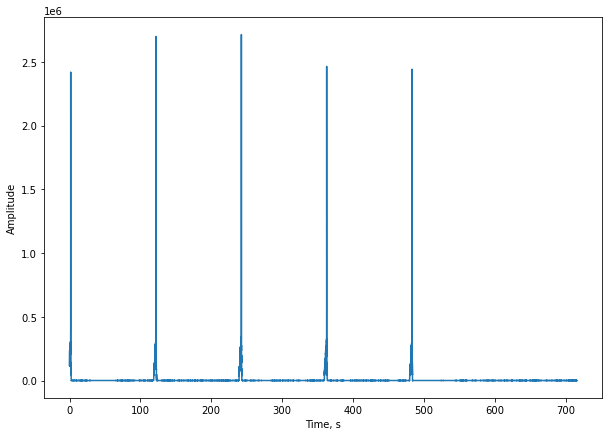

In [34]:
plt.figure(figsize=(10, 7))
detect_func_for_show = detect_func[:]
detect_func_len = len(detect_func_for_show)
times = np.linspace(0.0, detect_func_len*dt, detect_func_len)
plt.plot(times, detect_func_for_show)
plt.xlabel('Time, s')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
detect_func_patch = np.array([], dtype=np.float64)
for i in range(n_seismograms):
    detect_func_patch = np.concatenate((detect_func_patch, np.load('{}_{}.npy'.format(detect_function_prefix_patch, i))[:]['event']))
detect_func_patch.shape

In [ ]:
plt.figure(figsize=(10, 7))
detect_func_patch_for_show = detect_func_patch[:200000]
detect_func_len = len(detect_func_patch_for_show)
times = np.linspace(0.0, detect_func_len*dt, detect_func_len)
plt.plot(times, detect_func_patch_for_show)
plt.xlabel('Time, s')
plt.ylabel('Amplitude')
plt.show()

In [30]:
detect_func_rays = np.array([], dtype=np.float64)
for i in range(n_seismograms):
    detect_func_rays = np.concatenate((detect_func_rays, np.load('{}_{}.npy'.format(detect_function_prefix_rays, i))[:]['event']))
detect_func_rays.shape

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/nfs/Data/vershinin/microseismic/result/detect_function_rays_0.npy'

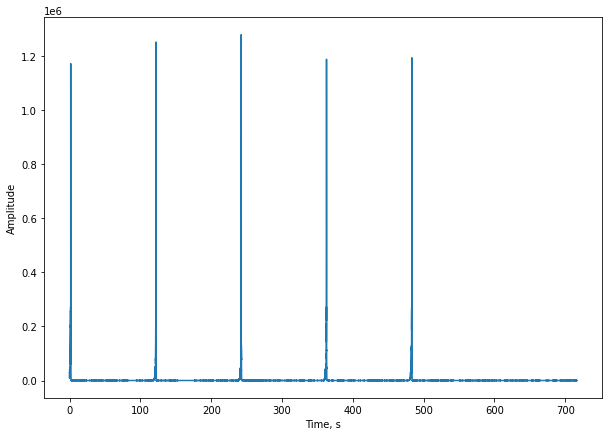

In [17]:
plt.figure(figsize=(10, 7))
detect_func_rays_for_show = detect_func_rays
detect_func_len = len(detect_func_rays_for_show)
times = np.linspace(0.0, detect_func_len*dt, detect_func_len)
plt.plot(times, detect_func_rays_for_show)
plt.xlabel('Time, s')
plt.ylabel('Amplitude')
plt.show()